# Logo plots with overlays
This Python Jupyter notebook plots escape map logo plots with overlays.

## Imports and configuration
Import Python modules:

In [1]:
import os

import Bio.SeqIO

import dmslogo
import dmslogo.colorschemes

from IPython.display import display, HTML

import matplotlib.cm
import matplotlib.colors
import matplotlib.pyplot as plt

import numpy

import pandas as pd

import yaml

Matplotlib is building the font cache using fc-list. This may take a moment.


Get configuration:

In [2]:
with open('../config.yaml') as f:
    config = yaml.safe_load(f)
    
with open('logo_overlays_config.yaml') as f:
    logo_overlays_config = yaml.safe_load(f)
    
results_dir = './results/'
os.makedirs(results_dir, exist_ok=True)

## Read site_color_schemes

In [3]:
print(f"Reading the site color schemes from ../{config['site_color_schemes']}")
site_color_schemes = pd.read_csv(os.path.join('../', config['site_color_schemes']))

Reading the site color schemes from ../data/site_color_schemes.csv


## Read escape fractions
Read the escape fractions, only keeping average of libraries:

In [4]:
mut_metric = config['mut_metric']
site_metric = config['site_metric']

escape_fracs = (pd.read_csv(os.path.join('../', config['escape_fracs']))
                .query('library == "average"')
                .drop(columns=['site', 'selection', 'library'])
                .rename(columns={'label_site': 'site'})
                )
print('First few lines of escape-fraction data frame:')
display(HTML(escape_fracs.head().to_html(index=False)))

First few lines of escape-fraction data frame:


condition,site,wildtype,mutation,protein_chain,protein_site,mut_escape_frac_epistasis_model,mut_escape_frac_single_mut,site_total_escape_frac_epistasis_model,site_total_escape_frac_single_mut,site_avg_escape_frac_epistasis_model,site_avg_escape_frac_single_mut,nlibs
CB6_400,331,N,A,E,331,0.001044,0.004109,0.03952,0.06292,0.00247,0.003932,2
CB6_400,331,N,D,E,331,0.002087,0.001886,0.03952,0.06292,0.00247,0.003932,1
CB6_400,331,N,E,E,331,0.001044,0.001399,0.03952,0.06292,0.00247,0.003932,2
CB6_400,331,N,F,E,331,0.001044,0.000753,0.03952,0.06292,0.00247,0.003932,2
CB6_400,331,N,G,E,331,0.005013,0.027988,0.03952,0.06292,0.00247,0.003932,2


Some sites / mutations are totally missing in the `escape_fracs` data frame.
For plotting with `dmslogo`, we need to pad these missing sites to be zero:

In [5]:
# make "padding" data frame covering all conditions, sites, and mutations
first_site = escape_fracs['site'].min()
last_site = escape_fracs['site'].max()
mutations = escape_fracs['mutation'].unique()
pad_df = pd.concat([pd.DataFrame({'condition': condition,
                                  'site': site,
                                  'mutation': mutations})
                    for condition in escape_fracs['condition'].unique()
                    for site in range(first_site, last_site + 1)])

# need to read in wildtype and map site to wildtype
wt_prot = str(Bio.SeqIO.read(os.path.join('../', config['wildtype_sequence']), 'fasta').seq.translate())
assert len(wt_prot) == last_site - first_site + 1
site_to_wt = {site: wt_prot[site - first_site] for site in range(first_site, last_site + 1)}
for site, wt in escape_fracs.set_index('site')['wildtype'].to_dict().items():
    if wt != site_to_wt[site]:
        raise ValueError(site, wt, site_to_wt[site])

# pad escape fracs data frame
escape_fracs_padded = (
    escape_fracs
    [['condition', 'site', 'mutation', site_metric, mut_metric]]
    .merge(pad_df, how='outer')
    .fillna(0)
    .assign(wildtype=lambda x: x['site'].map(site_to_wt),
            wt_site=lambda x: x['wildtype'] + x['site'].astype(str))
    .assign(**{site_metric: lambda x: x.groupby(['condition', 'site'])[site_metric].transform('max')})
    )

## Color by deep mutational scanning data
We add columns to the data frame that enable coloring of the logo plots by the deep mutational scanning measurements of binding or expression.
We choose a color scheme that spans the min and maximum values for all letters with non-zero height (the mutation-level metric > 0).
We also write out the scale bar for this coloring.

Importantly, **note that as long as `clip_vals_gt_0` is set to `True`, then all DMS values greater than 0 (beneficial mutations) are set to zero**.
For publications, the scale bar should be manually edited to change "0" to ">0" to reflect this fact.


bind ranges from -2.33 to 0.0, here is the scale bar, which is being saved to ./results/bind_scalebar_horizontal.pdf


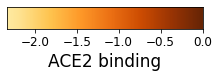


bind ranges from -2.33 to 0.0, here is the scale bar, which is being saved to ./results/bind_scalebar_vertical.pdf


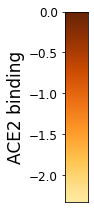


expr ranges from -1.0 to 0.0, here is the scale bar, which is being saved to ./results/expr_scalebar_horizontal.pdf


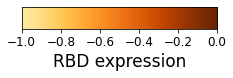


expr ranges from -1.0 to 0.0, here is the scale bar, which is being saved to ./results/expr_scalebar_vertical.pdf


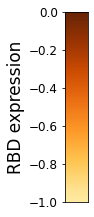

In [6]:
clip_vals_gt_0 = True  # plot DMS values > 0 as 0 (grouping beneficial and neutral)

# read DMS data flagging mutations with escape > 0
mut_bind_expr = (
    pd.read_csv(os.path.join('../', config['mut_bind_expr']))
    [['site_SARS2', 'mutant', 'bind_avg', 'expr_avg']]
    .rename(columns={'site_SARS2': 'site',
                     'mutant': 'mutation',
                     'bind_avg': 'bind',
                     'expr_avg': 'expr'})
    # flag mutations with mutation escape > 0
    .merge(escape_fracs_padded, how='right', validate='one_to_many', on=['site', 'mutation'])
    .assign(escape_gt_0=lambda x: x[mut_metric] > 0)
    .groupby(['site', 'mutation', 'bind', 'expr'])
    .aggregate(escape_gt_0=pd.NamedAgg('escape_gt_0', 'any'))
    .reset_index()
    .drop_duplicates()
    )

# add color for each mutation, coloring those without escape > 0 as white
for prop in ['bind', 'expr']:
    
    # set up color scale and draw scale bard
    min_prop = mut_bind_expr.query('escape_gt_0')[prop].min()
    if clip_vals_gt_0:
        mut_bind_expr[prop] = numpy.clip(mut_bind_expr[prop], None, 0)
    max_prop = mut_bind_expr.query('escape_gt_0')[prop].max()
    # get YlOrBr color map (https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html),
    # but start 20% in so not too faint: https://stackoverflow.com/a/18926541
    nsegments = 256
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            name='trunc_YlOrBr',
            colors=matplotlib.cm.get_cmap('YlOrBr', lut=256)(numpy.linspace(0.2, 1, 256))
            )
    colormap = dmslogo.colorschemes.ValueToColorMap(
                    minvalue=min_prop,
                    maxvalue=max_prop,
                    cmap=cmap,
                    )
    for orientation in ['horizontal', 'vertical']:
        scalebar_file = os.path.join(results_dir, f"{prop}_scalebar_{orientation}.pdf")
        print(f"\n{prop} ranges from {min_prop} to {max_prop}, here is the scale bar, which is being saved to {scalebar_file}")
        fig, _ = colormap.scale_bar(orientation=orientation,
                                    label={'bind': 'ACE2 binding',
                                           'expr': 'RBD expression'}[prop])
        fig.savefig(scalebar_file, bbox_inches='tight')
        display(fig)
        plt.close(fig)
    
    # add color to data frame of DMS data
    mut_bind_expr[f"{prop}_color"] = mut_bind_expr.apply(lambda r: colormap.val_to_color(r[prop]) if r['escape_gt_0'] else 'white',
                                                         axis=1)
    
# add DMS coloring to escape fractions data frame
escape_fracs_padded = (
    escape_fracs_padded
    .drop(columns=['bind_color', 'expr_color'], errors='ignore')
    .merge(mut_bind_expr[['site', 'mutation', 'bind_color', 'expr_color']],
           how='left',
           validate='many_to_one',
           on=['site', 'mutation'])
    # assign colors that are NaN and have 0 height to be white
    .assign(bind_color=lambda x: x['bind_color'].where((x[mut_metric] != 0) | x['bind_color'].notnull(),
                                                       'white'),
            expr_color=lambda x: x['expr_color'].where((x[mut_metric] != 0) | x['expr_color'].notnull(),
                                                       'white'),
            )
    )
# check no letters have NaN colors
nan_color = (
    escape_fracs_padded
    .query('bind_color.isnull() | expr_color.isnull()')
    )
if len(nan_color):
    raise ValueError(f"The following entries lack colors:\n{nan_color}")

## Plot logos with overlays
Loop over all of the logos to draw:


Drawing logo for Vir_core:
S309_421


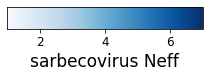

Saving overlay scale bar to ./results/Vir_core_sarbecovirus_Neff_horizontal.pdf
Saving overlay scale bar to ./results/Vir_core_sarbecovirus_Neff_vertical.pdf


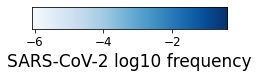

Saving overlay scale bar to ./results/Vir_core_SARS-CoV-2_log10_frequency_horizontal.pdf
Saving overlay scale bar to ./results/Vir_core_SARS-CoV-2_log10_frequency_vertical.pdf


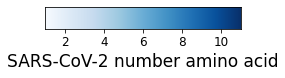

Saving overlay scale bar to ./results/Vir_core_SARS-CoV-2_number_amino_acid_horizontal.pdf
Saving overlay scale bar to ./results/Vir_core_SARS-CoV-2_number_amino_acid_vertical.pdf


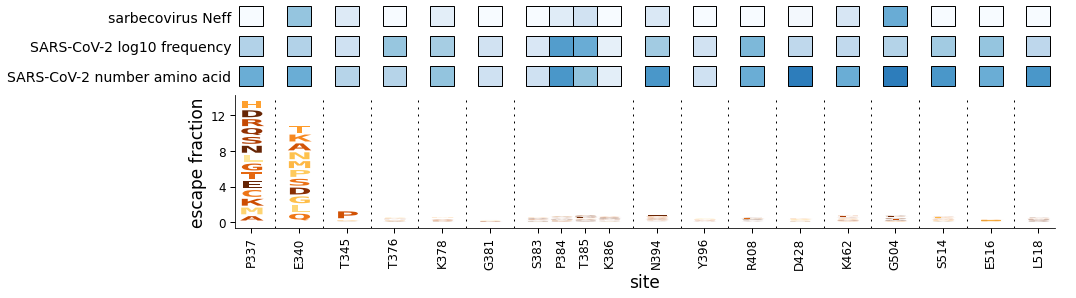

Saving logo plot to ./results/Vir_core_logo.pdf

Drawing logo for Vir_RBM:
S2E12_56


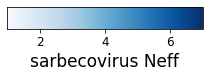

Saving overlay scale bar to ./results/Vir_RBM_sarbecovirus_Neff_horizontal.pdf
Saving overlay scale bar to ./results/Vir_RBM_sarbecovirus_Neff_vertical.pdf


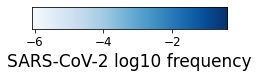

Saving overlay scale bar to ./results/Vir_RBM_SARS-CoV-2_log10_frequency_horizontal.pdf
Saving overlay scale bar to ./results/Vir_RBM_SARS-CoV-2_log10_frequency_vertical.pdf


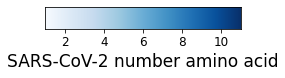

Saving overlay scale bar to ./results/Vir_RBM_SARS-CoV-2_number_amino_acid_horizontal.pdf
Saving overlay scale bar to ./results/Vir_RBM_SARS-CoV-2_number_amino_acid_vertical.pdf


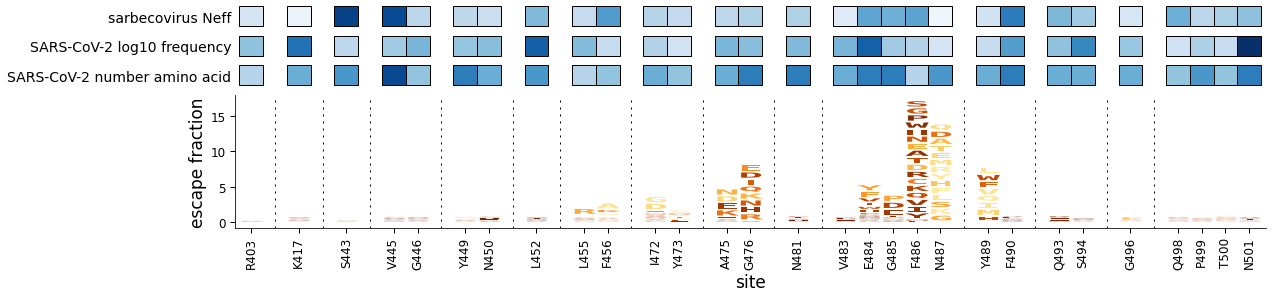

Saving logo plot to ./results/Vir_RBM_logo.pdf

Drawing logo for S309_epitope:
S309_421


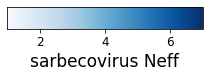

Saving overlay scale bar to ./results/S309_epitope_sarbecovirus_Neff_horizontal.pdf
Saving overlay scale bar to ./results/S309_epitope_sarbecovirus_Neff_vertical.pdf


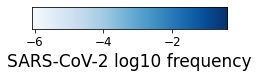

Saving overlay scale bar to ./results/S309_epitope_SARS-CoV-2_log10_frequency_horizontal.pdf
Saving overlay scale bar to ./results/S309_epitope_SARS-CoV-2_log10_frequency_vertical.pdf


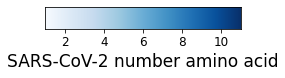

Saving overlay scale bar to ./results/S309_epitope_SARS-CoV-2_number_amino_acid_horizontal.pdf
Saving overlay scale bar to ./results/S309_epitope_SARS-CoV-2_number_amino_acid_vertical.pdf


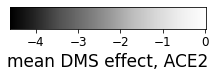

Saving overlay scale bar to ./results/S309_epitope_mean_DMS_effect,_ACE2_horizontal.pdf
Saving overlay scale bar to ./results/S309_epitope_mean_DMS_effect,_ACE2_vertical.pdf


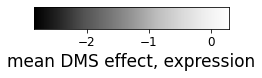

Saving overlay scale bar to ./results/S309_epitope_mean_DMS_effect,_expression_horizontal.pdf
Saving overlay scale bar to ./results/S309_epitope_mean_DMS_effect,_expression_vertical.pdf


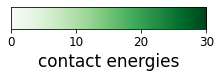

Saving overlay scale bar to ./results/S309_epitope_contact_energies_horizontal.pdf
Saving overlay scale bar to ./results/S309_epitope_contact_energies_vertical.pdf


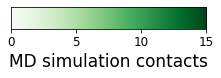

Saving overlay scale bar to ./results/S309_epitope_MD_simulation_contacts_horizontal.pdf
Saving overlay scale bar to ./results/S309_epitope_MD_simulation_contacts_vertical.pdf


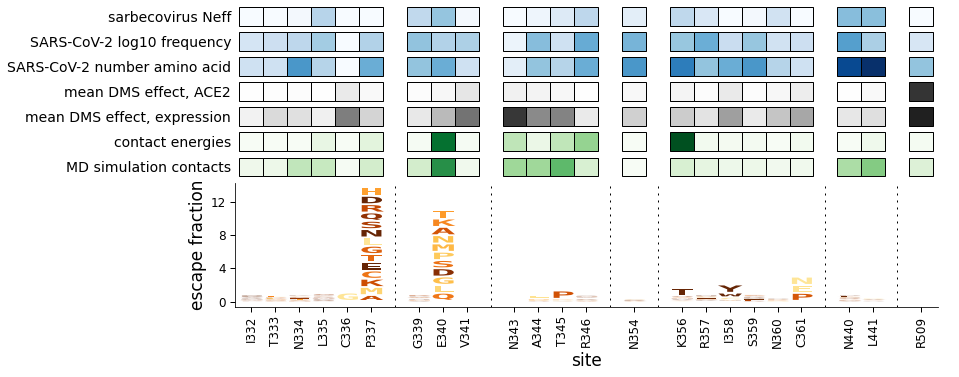

Saving logo plot to ./results/S309_epitope_logo.pdf

Drawing logo for S2E12_epitope:
S2E12_56


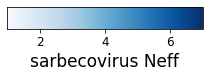

Saving overlay scale bar to ./results/S2E12_epitope_sarbecovirus_Neff_horizontal.pdf
Saving overlay scale bar to ./results/S2E12_epitope_sarbecovirus_Neff_vertical.pdf


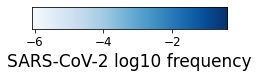

Saving overlay scale bar to ./results/S2E12_epitope_SARS-CoV-2_log10_frequency_horizontal.pdf
Saving overlay scale bar to ./results/S2E12_epitope_SARS-CoV-2_log10_frequency_vertical.pdf


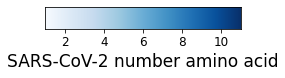

Saving overlay scale bar to ./results/S2E12_epitope_SARS-CoV-2_number_amino_acid_horizontal.pdf
Saving overlay scale bar to ./results/S2E12_epitope_SARS-CoV-2_number_amino_acid_vertical.pdf


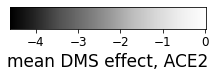

Saving overlay scale bar to ./results/S2E12_epitope_mean_DMS_effect,_ACE2_horizontal.pdf
Saving overlay scale bar to ./results/S2E12_epitope_mean_DMS_effect,_ACE2_vertical.pdf


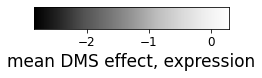

Saving overlay scale bar to ./results/S2E12_epitope_mean_DMS_effect,_expression_horizontal.pdf
Saving overlay scale bar to ./results/S2E12_epitope_mean_DMS_effect,_expression_vertical.pdf


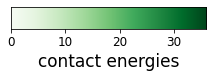

Saving overlay scale bar to ./results/S2E12_epitope_contact_energies_horizontal.pdf
Saving overlay scale bar to ./results/S2E12_epitope_contact_energies_vertical.pdf


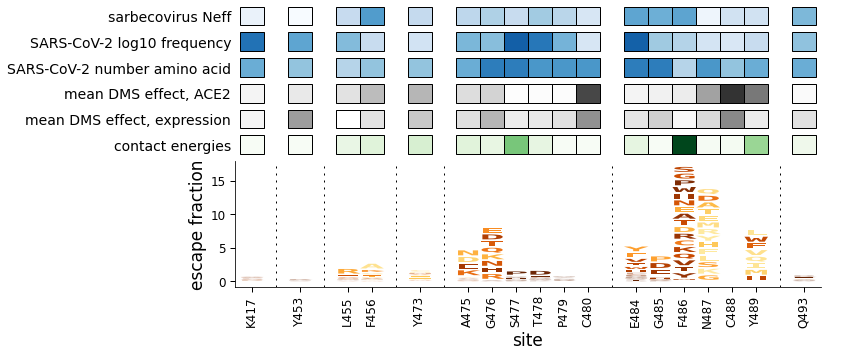

Saving logo plot to ./results/S2E12_epitope_logo.pdf

Drawing logo for S2D106_epitope:
S2D106_68


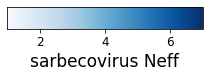

Saving overlay scale bar to ./results/S2D106_epitope_sarbecovirus_Neff_horizontal.pdf
Saving overlay scale bar to ./results/S2D106_epitope_sarbecovirus_Neff_vertical.pdf


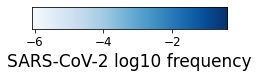

Saving overlay scale bar to ./results/S2D106_epitope_SARS-CoV-2_log10_frequency_horizontal.pdf
Saving overlay scale bar to ./results/S2D106_epitope_SARS-CoV-2_log10_frequency_vertical.pdf


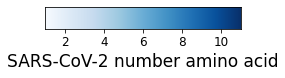

Saving overlay scale bar to ./results/S2D106_epitope_SARS-CoV-2_number_amino_acid_horizontal.pdf
Saving overlay scale bar to ./results/S2D106_epitope_SARS-CoV-2_number_amino_acid_vertical.pdf


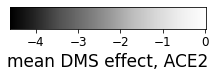

Saving overlay scale bar to ./results/S2D106_epitope_mean_DMS_effect,_ACE2_horizontal.pdf
Saving overlay scale bar to ./results/S2D106_epitope_mean_DMS_effect,_ACE2_vertical.pdf


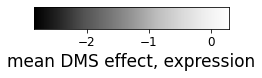

Saving overlay scale bar to ./results/S2D106_epitope_mean_DMS_effect,_expression_horizontal.pdf
Saving overlay scale bar to ./results/S2D106_epitope_mean_DMS_effect,_expression_vertical.pdf


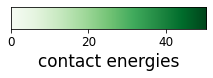

Saving overlay scale bar to ./results/S2D106_epitope_contact_energies_horizontal.pdf
Saving overlay scale bar to ./results/S2D106_epitope_contact_energies_vertical.pdf


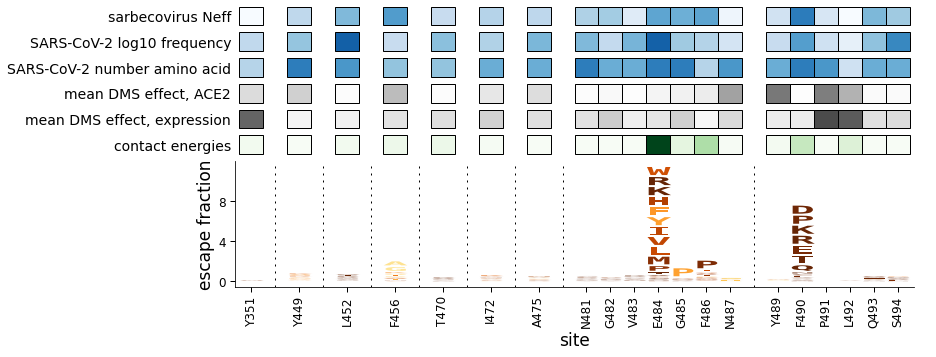

Saving logo plot to ./results/S2D106_epitope_logo.pdf

Drawing logo for S304_epitope:
S304_46


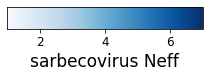

Saving overlay scale bar to ./results/S304_epitope_sarbecovirus_Neff_horizontal.pdf
Saving overlay scale bar to ./results/S304_epitope_sarbecovirus_Neff_vertical.pdf


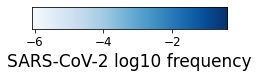

Saving overlay scale bar to ./results/S304_epitope_SARS-CoV-2_log10_frequency_horizontal.pdf
Saving overlay scale bar to ./results/S304_epitope_SARS-CoV-2_log10_frequency_vertical.pdf


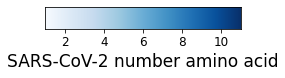

Saving overlay scale bar to ./results/S304_epitope_SARS-CoV-2_number_amino_acid_horizontal.pdf
Saving overlay scale bar to ./results/S304_epitope_SARS-CoV-2_number_amino_acid_vertical.pdf


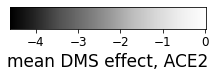

Saving overlay scale bar to ./results/S304_epitope_mean_DMS_effect,_ACE2_horizontal.pdf
Saving overlay scale bar to ./results/S304_epitope_mean_DMS_effect,_ACE2_vertical.pdf


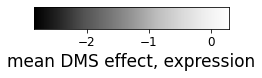

Saving overlay scale bar to ./results/S304_epitope_mean_DMS_effect,_expression_horizontal.pdf
Saving overlay scale bar to ./results/S304_epitope_mean_DMS_effect,_expression_vertical.pdf


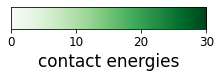

Saving overlay scale bar to ./results/S304_epitope_contact_energies_horizontal.pdf
Saving overlay scale bar to ./results/S304_epitope_contact_energies_vertical.pdf


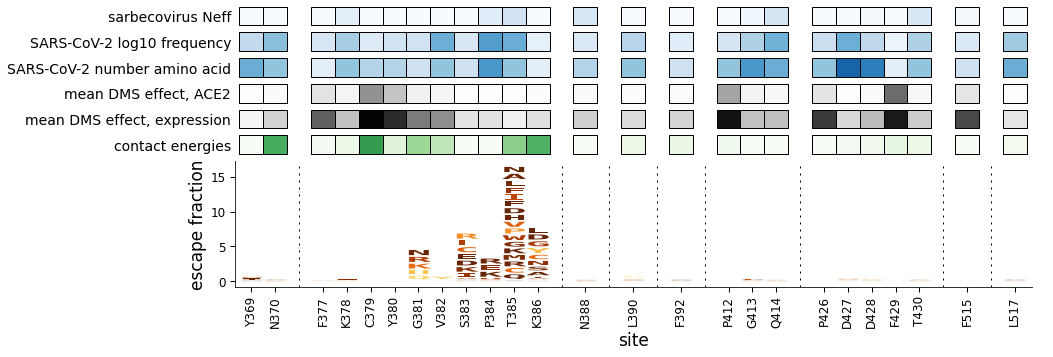

Saving logo plot to ./results/S304_epitope_logo.pdf

Drawing logo for S2X35_epitope:
S2X35_70


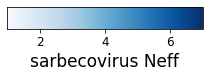

Saving overlay scale bar to ./results/S2X35_epitope_sarbecovirus_Neff_horizontal.pdf
Saving overlay scale bar to ./results/S2X35_epitope_sarbecovirus_Neff_vertical.pdf


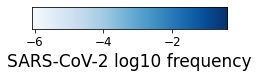

Saving overlay scale bar to ./results/S2X35_epitope_SARS-CoV-2_log10_frequency_horizontal.pdf
Saving overlay scale bar to ./results/S2X35_epitope_SARS-CoV-2_log10_frequency_vertical.pdf


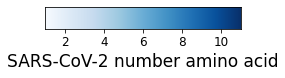

Saving overlay scale bar to ./results/S2X35_epitope_SARS-CoV-2_number_amino_acid_horizontal.pdf
Saving overlay scale bar to ./results/S2X35_epitope_SARS-CoV-2_number_amino_acid_vertical.pdf


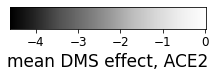

Saving overlay scale bar to ./results/S2X35_epitope_mean_DMS_effect,_ACE2_horizontal.pdf
Saving overlay scale bar to ./results/S2X35_epitope_mean_DMS_effect,_ACE2_vertical.pdf


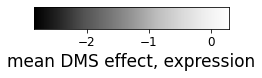

Saving overlay scale bar to ./results/S2X35_epitope_mean_DMS_effect,_expression_horizontal.pdf
Saving overlay scale bar to ./results/S2X35_epitope_mean_DMS_effect,_expression_vertical.pdf


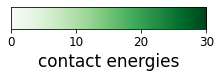

Saving overlay scale bar to ./results/S2X35_epitope_contact_energies_horizontal.pdf
Saving overlay scale bar to ./results/S2X35_epitope_contact_energies_vertical.pdf


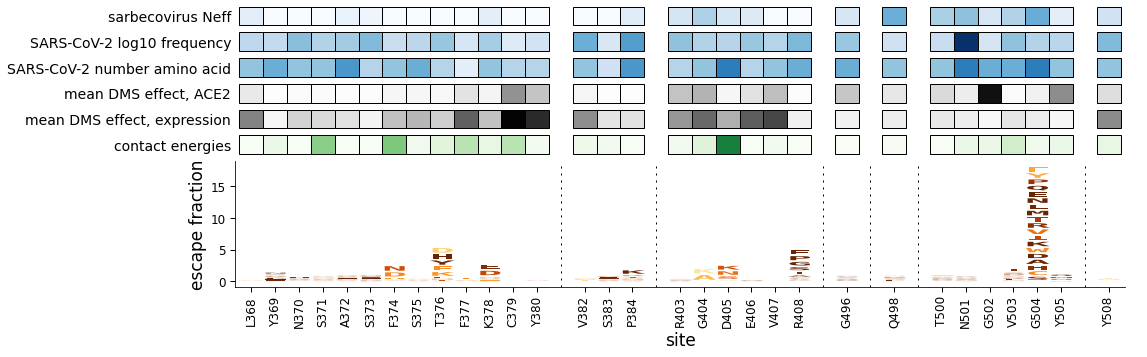

Saving logo plot to ./results/S2X35_epitope_logo.pdf

Drawing logo for S2H14_epitope:
S2H14_105


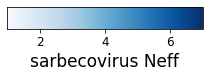

Saving overlay scale bar to ./results/S2H14_epitope_sarbecovirus_Neff_horizontal.pdf
Saving overlay scale bar to ./results/S2H14_epitope_sarbecovirus_Neff_vertical.pdf


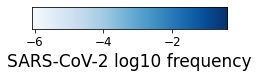

Saving overlay scale bar to ./results/S2H14_epitope_SARS-CoV-2_log10_frequency_horizontal.pdf
Saving overlay scale bar to ./results/S2H14_epitope_SARS-CoV-2_log10_frequency_vertical.pdf


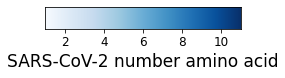

Saving overlay scale bar to ./results/S2H14_epitope_SARS-CoV-2_number_amino_acid_horizontal.pdf
Saving overlay scale bar to ./results/S2H14_epitope_SARS-CoV-2_number_amino_acid_vertical.pdf


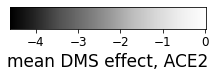

Saving overlay scale bar to ./results/S2H14_epitope_mean_DMS_effect,_ACE2_horizontal.pdf
Saving overlay scale bar to ./results/S2H14_epitope_mean_DMS_effect,_ACE2_vertical.pdf


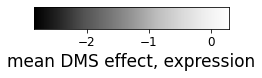

Saving overlay scale bar to ./results/S2H14_epitope_mean_DMS_effect,_expression_horizontal.pdf
Saving overlay scale bar to ./results/S2H14_epitope_mean_DMS_effect,_expression_vertical.pdf


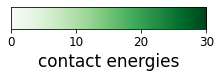

Saving overlay scale bar to ./results/S2H14_epitope_contact_energies_horizontal.pdf
Saving overlay scale bar to ./results/S2H14_epitope_contact_energies_vertical.pdf


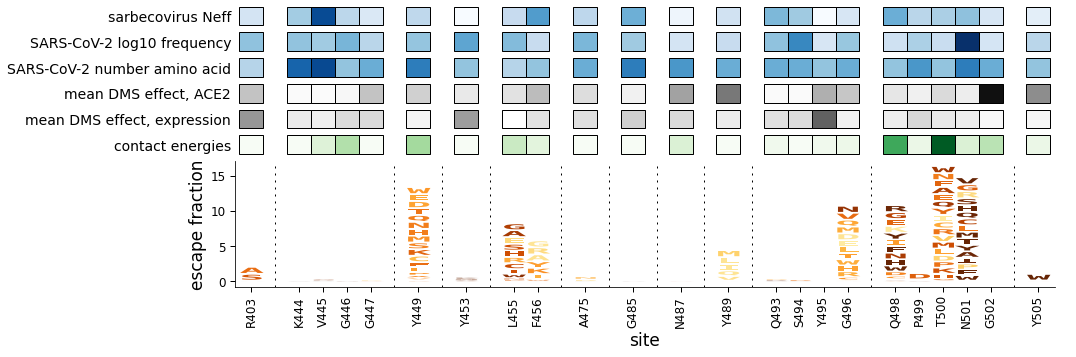

Saving logo plot to ./results/S2H14_epitope_logo.pdf

Drawing logo for S2X259_epitope:
S2X259_59


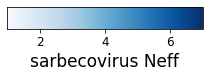

Saving overlay scale bar to ./results/S2X259_epitope_sarbecovirus_Neff_horizontal.pdf
Saving overlay scale bar to ./results/S2X259_epitope_sarbecovirus_Neff_vertical.pdf


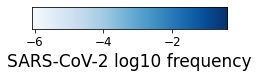

Saving overlay scale bar to ./results/S2X259_epitope_SARS-CoV-2_log10_frequency_horizontal.pdf
Saving overlay scale bar to ./results/S2X259_epitope_SARS-CoV-2_log10_frequency_vertical.pdf


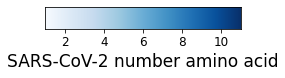

Saving overlay scale bar to ./results/S2X259_epitope_SARS-CoV-2_number_amino_acid_horizontal.pdf
Saving overlay scale bar to ./results/S2X259_epitope_SARS-CoV-2_number_amino_acid_vertical.pdf


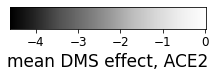

Saving overlay scale bar to ./results/S2X259_epitope_mean_DMS_effect,_ACE2_horizontal.pdf
Saving overlay scale bar to ./results/S2X259_epitope_mean_DMS_effect,_ACE2_vertical.pdf


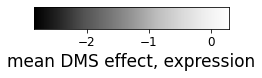

Saving overlay scale bar to ./results/S2X259_epitope_mean_DMS_effect,_expression_horizontal.pdf
Saving overlay scale bar to ./results/S2X259_epitope_mean_DMS_effect,_expression_vertical.pdf


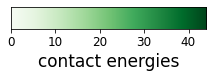

Saving overlay scale bar to ./results/S2X259_epitope_contact_energies_horizontal.pdf
Saving overlay scale bar to ./results/S2X259_epitope_contact_energies_vertical.pdf


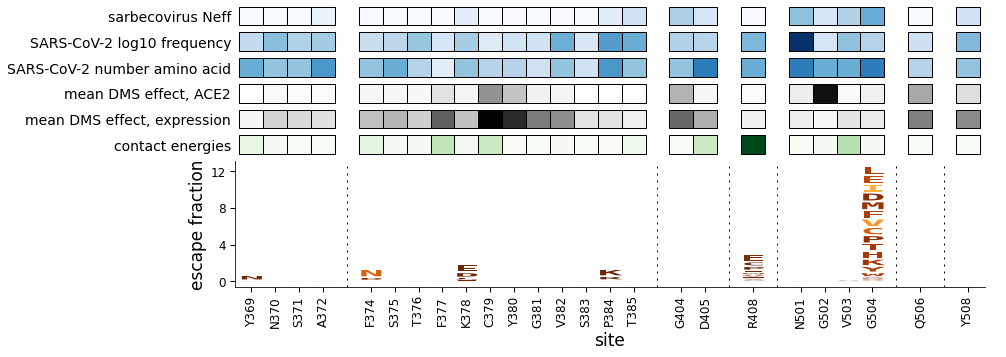

Saving logo plot to ./results/S2X259_epitope_logo.pdf

Drawing logo for S2H13_epitope:
S2H13_56


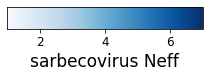

Saving overlay scale bar to ./results/S2H13_epitope_sarbecovirus_Neff_horizontal.pdf
Saving overlay scale bar to ./results/S2H13_epitope_sarbecovirus_Neff_vertical.pdf


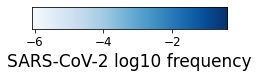

Saving overlay scale bar to ./results/S2H13_epitope_SARS-CoV-2_log10_frequency_horizontal.pdf
Saving overlay scale bar to ./results/S2H13_epitope_SARS-CoV-2_log10_frequency_vertical.pdf


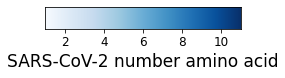

Saving overlay scale bar to ./results/S2H13_epitope_SARS-CoV-2_number_amino_acid_horizontal.pdf
Saving overlay scale bar to ./results/S2H13_epitope_SARS-CoV-2_number_amino_acid_vertical.pdf


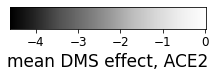

Saving overlay scale bar to ./results/S2H13_epitope_mean_DMS_effect,_ACE2_horizontal.pdf
Saving overlay scale bar to ./results/S2H13_epitope_mean_DMS_effect,_ACE2_vertical.pdf


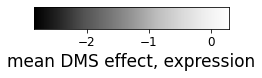

Saving overlay scale bar to ./results/S2H13_epitope_mean_DMS_effect,_expression_horizontal.pdf
Saving overlay scale bar to ./results/S2H13_epitope_mean_DMS_effect,_expression_vertical.pdf


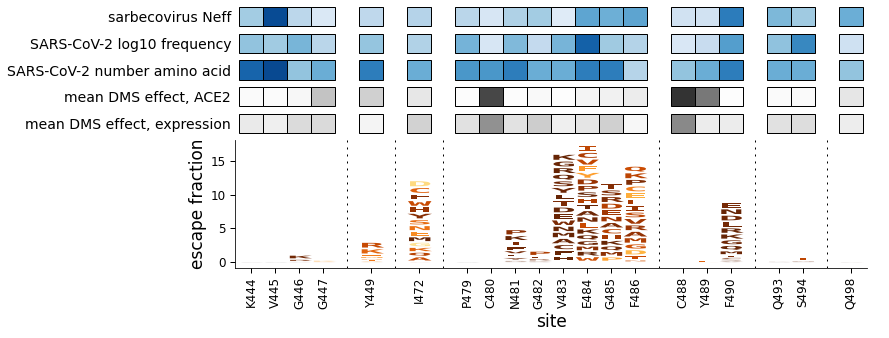

Saving logo plot to ./results/S2H13_epitope_logo.pdf

Drawing logo for S2H97_epitope:
S2H97_58


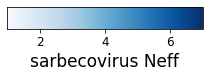

Saving overlay scale bar to ./results/S2H97_epitope_sarbecovirus_Neff_horizontal.pdf
Saving overlay scale bar to ./results/S2H97_epitope_sarbecovirus_Neff_vertical.pdf


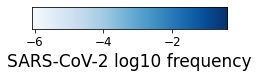

Saving overlay scale bar to ./results/S2H97_epitope_SARS-CoV-2_log10_frequency_horizontal.pdf
Saving overlay scale bar to ./results/S2H97_epitope_SARS-CoV-2_log10_frequency_vertical.pdf


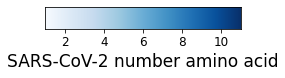

Saving overlay scale bar to ./results/S2H97_epitope_SARS-CoV-2_number_amino_acid_horizontal.pdf
Saving overlay scale bar to ./results/S2H97_epitope_SARS-CoV-2_number_amino_acid_vertical.pdf


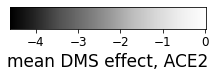

Saving overlay scale bar to ./results/S2H97_epitope_mean_DMS_effect,_ACE2_horizontal.pdf
Saving overlay scale bar to ./results/S2H97_epitope_mean_DMS_effect,_ACE2_vertical.pdf


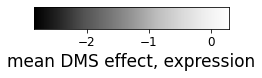

Saving overlay scale bar to ./results/S2H97_epitope_mean_DMS_effect,_expression_horizontal.pdf
Saving overlay scale bar to ./results/S2H97_epitope_mean_DMS_effect,_expression_vertical.pdf


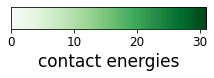

Saving overlay scale bar to ./results/S2H97_epitope_contact_energies_horizontal.pdf
Saving overlay scale bar to ./results/S2H97_epitope_contact_energies_vertical.pdf


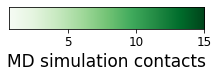

Saving overlay scale bar to ./results/S2H97_epitope_MD_simulation_contacts_horizontal.pdf
Saving overlay scale bar to ./results/S2H97_epitope_MD_simulation_contacts_vertical.pdf


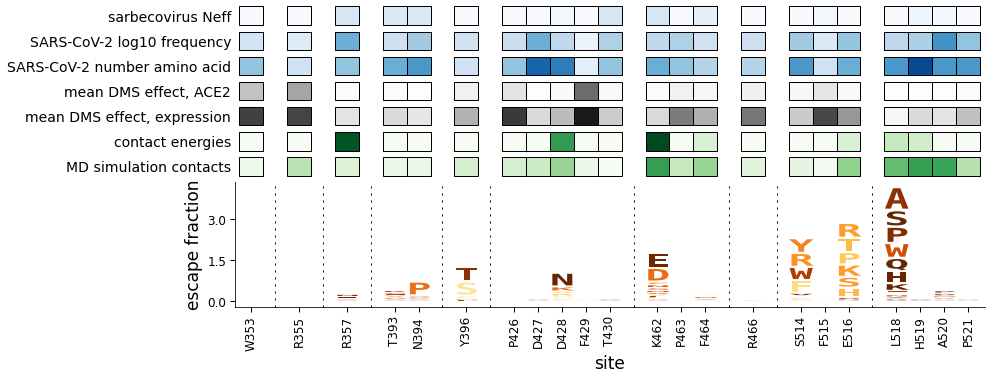

Saving logo plot to ./results/S2H97_epitope_logo.pdf


In [7]:
for name, specs in logo_overlays_config.items():
    print(f"\nDrawing logo for {name}:")
    
    # get relevant data frame with escape fractions
    print(specs['full_name'])
    df = escape_fracs_padded[escape_fracs_padded['condition'] == specs['full_name']]
    assert len(df), f"no escape fracs for {specs['full_name']}"
    missing_sites = set(specs['sites']) - set(df['site'])
    assert not missing_sites, f"missing these sites {missing_sites}"
    df = df[df['site'].isin(specs['sites'])]
    
    # determine how we are coloring letters
    if specs['letter_colors'] in {'bind_color', 'expr_color'}:
        df['color'] = df[specs['letter_colors']]
    else:
        df['color'] = specs['letter_colors']
    
    # is there a site color scheme?
    color_col = None
    if 'site_color_scheme' in specs:
        color_col = 'color'
        if specs['site_color_scheme'] in site_color_schemes.columns:
            # color scheme specified by site
            site_colors = site_color_schemes.set_index('site')[specs['site_color_scheme']].to_dict()
            df = df.assign(color=lambda x: x['site'].map(site_colors))
        else:
            # color specified for all sites
            df = df.assign(color=specs['site_color_scheme'])
    # is there a mutation color specification?
    if 'mutation_colors' in specs:
        assert 'site_color_scheme' in specs, 'must specify site-color scheme for mutation colors'
        def mut_color(row):
            key = f"{row['mutation']}{row['site']}"
            if key in specs['mutation_colors']:
                return specs['mutation_colors'][key]
            else:
                return row[color_col]
        df = df.assign(color=lambda x: x.apply(mut_color, axis=1))
        
    # read additional site-level properties
    for site_prop, prop_d in specs['site_info'].items():
        assert site_prop not in df.columns, f"duplicate property {site_prop}"
        site_prop_df = pd.read_csv(prop_d['csv'])
        if prop_d['antibody_col']:
            antibody_col = prop_d['antibody_col']
            if specs['short_name'] in site_prop_df[antibody_col].unique():
                site_prop_df = site_prop_df[site_prop_df[antibody_col] == specs['short_name']]
            elif specs['full_name'] in site_prop_df[antibody_col].unique():
                site_prop_df = site_prop_df[site_prop_df[antibody_col] == specs['full_name']]
            else:
                raise ValueError(f"cannot find antibody for {name} for site info {site_prop}")
        site_prop_df = (site_prop_df
                        .rename(columns={prop_d['val_col']: site_prop, prop_d['site_col']: 'site'},
                                errors='raise')
                        [['site', site_prop]]
                        .drop_duplicates()
                        )
        assert len(site_prop_df) == site_prop_df['site'].nunique(), f"duplicate entries for {site_prop}"
        df = df.merge(site_prop_df, how='left', on='site', validate='many_to_one')
        df[site_prop].fillna(prop_d['missing_vals'])
        
    # set up overlays
    heatmap_overlays = []
    for overlay, overlay_specs in specs['overlays'].items():
        assert overlay in df.columns.unique(), f"missing data for {overlay} overlay"
        cmap = dmslogo.colorschemes.ValueToColorMap(
                minvalue=overlay_specs['min'] if overlay_specs['min'] else df[overlay].min(),
                maxvalue=overlay_specs['max'] if overlay_specs['max'] else df[overlay].max(),
                cmap=overlay_specs['color_scale'],
                )
        for orientation in ['horizontal', 'vertical']:
            cmap_scale, _ = cmap.scale_bar(orientation=orientation, label=overlay)
            if orientation == 'horizontal':
                display(cmap_scale)
            fname = os.path.join(results_dir, f"{name}_{overlay.replace(' ', '_')}_{orientation}.pdf")
            print(f"Saving overlay scale bar to {fname}")
            cmap_scale.savefig(fname, bbox_inches='tight')
            plt.close(cmap_scale)
        df[overlay] = cmap.val_to_color(df[overlay])
        heatmap_overlays.append(overlay)
        
    # set up any shading
    shade_color = specs['shading']['property']
    if shade_color:
        assert shade_color not in heatmap_overlays, f"shade color {shade_color} already an overlay"
        shade_specs = specs['shading']
        df['shade_alpha'] = shade_specs['alpha']
        cmap = dmslogo.colorschemes.ValueToColorMap(
                minvalue=shade_specs['min'] if shade_specs['min'] else df[shade_color].min(),
                maxvalue=shade_specs['min'] if shade_specs['max'] else df[shade_color].max(),
                cmap=shade_specs['color_scale'],
                )
        for orientation in ['horizontal', 'vertical']:
            cmap_scale, _ = cmap.scale_bar(orientation=orientation,
                                           label=shade_color,
                                           alpha=shade_specs['alpha'])
            if orientation == 'horizontal':
                display(cmap_scale)
            fname = os.path.join(results_dir, f"{name}_{shade_color.replace(' ', '_')}_{orientation}.pdf")
            print(f"Saving shading scale bar to {fname}")
            cmap_scale.savefig(fname, bbox_inches='tight')
            plt.close(cmap_scale)
        df[shade_color] = cmap.val_to_color(df[shade_color])

    # draw logo
    fig, _ = dmslogo.draw_logo(
                    data=df,
                    x_col='site',
                    letter_col='mutation',
                    letter_height_col=mut_metric,
                    xtick_col='wt_site',
                    color_col='color',
                    shade_color_col=shade_color,
                    shade_alpha_col='shade_alpha' if shade_color else None,
                    xlabel='site',
                    ylabel='escape fraction',
                    heatmap_overlays=heatmap_overlays,
                    **specs['dmslogo_draw_logo_kwargs']
                    )
    display(fig)
    plotfile = os.path.join(results_dir, f"{name}_logo.pdf")
    print(f"Saving logo plot to {plotfile}")
    fig.savefig(plotfile, bbox_inches='tight')
    plt.close(fig)